In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
class AdaLineSGD:
    def __init__(self, lr=1e-1, batch_size=32, n_epoch=500, pbar=True):
        self.lr = lr
        self.batch_size = batch_size
        self.n_epoch = n_epoch
        self.pbar = pbar
        self.W = None
        self.b = None
    
    def fit(self, xs, ys):
        N, F = xs.shape
        n_step = N // self.batch_size
        self.W = np.random.normal(loc=0.0, scale=0.01, size=(F, 1))
        self.b = np.random.normal(loc=0.0, scale=0.01, size=(1,))
        
        epochs = range(self.n_epoch)
        if self.pbar:
            epochs = tqdm(epochs)
        
        for ep in epochs:
            indices = np.random.permutation(n_step * self.batch_size)
            avg_loss = 0.0
            for it in range(n_step):
                s = it * self.batch_size
                t = min(s + self.batch_size, N)
                x_batch = xs[indices[s:t]]
                y_batch = ys[indices[s:t]]
                loss = self.partial_fit(x_batch, y_batch)
                avg_loss = ((avg_loss * it) + loss) / (it + 1)
            yield avg_loss
            
    def partial_fit(self, x_batch, y_batch):
        B, F = x_batch.shape
        y_batch = np.expand_dims(y_batch, axis=-1) # [B, 1]
        p_batch = self.forward(x_batch) # [B, 1]
        l_batch = 0.5 * np.sum((y_batch - p_batch)**2, axis=1) # [B, 1]
        loss = l_batch.mean() # float
        
        dL = np.ones((B, 1)) / B # [B, 1]
        dP = dL * (p_batch - y_batch) # [B, 1]
        dW = x_batch.T @ dP # [F, 1]
        dB = dP # [B, 1]
        db = dB.sum(axis=0) # [1]
        
        self.W = self.W - self.lr * dW
        self.b = self.b - self.lr * db
        return float(loss)
    
    def forward(self, x_batch):
        return x_batch @ self.W + self.b
    
    def predict_proba(self, xs):
        return self.forward(xs).squeeze(axis=1)
    
    def predict(self, xs):
        prob = self.predict_proba(xs)
        return np.where(prob < 0.0, -1, 1)
    
    def score(self, xs, ys):
        ps = self.predict(xs)
        return (ps == ys).mean()

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

xt, xv, yt, yv = train_test_split(X, y, test_size=0.2)

std = StandardScaler()
std.fit(xt)
xt_std = std.transform(xt)
xv_std = std.transform(xv)

print(xt.shape, yt.shape)
print(xv.shape, yv.shape)

(80, 2) (80,)
(20, 2) (20,)


In [4]:
clf1 = AdaLineSGD(lr=1e-2, batch_size=1, n_epoch=70, pbar=False)
loss1 = list(clf1.fit(xt_std, yt))
acc1 = clf1.score(xv_std, yv)
print('Acc 1:', acc1)

clf2 = AdaLineSGD(lr=1e-2, batch_size=10, n_epoch=70, pbar=False)
loss2 = list(clf2.fit(xt_std, yt))
acc2 = clf2.score(xv_std, yv)
print('Acc 2:', acc2)

clf3 = AdaLineSGD(lr=1e-2, batch_size=40, n_epoch=70, pbar=False)
loss3 = list(clf3.fit(xt_std, yt))
acc3 = clf3.score(xv_std, yv)
print('Acc 3:', acc3)

Acc 1: 0.95
Acc 2: 0.95
Acc 3: 0.95


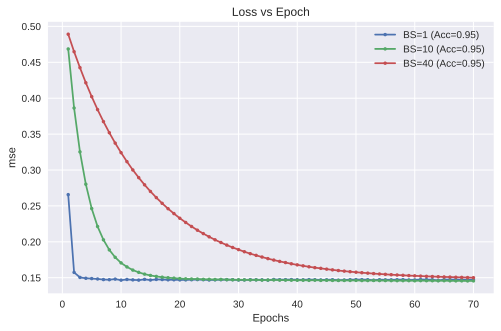

In [5]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 5))
ax.plot(np.arange(1, clf1.n_epoch + 1), loss1, '.-', label=f'BS=1 (Acc={acc1})')
ax.plot(np.arange(1, clf2.n_epoch + 1), loss2, '.-', label=f'BS=10 (Acc={acc2})')
ax.plot(np.arange(1, clf3.n_epoch + 1), loss3, '.-', label=f'BS=40 (Acc={acc3})')
ax.set_xlabel('Epochs')
ax.set_ylabel('mse')
ax.set_title('Loss vs Epoch')
ax.legend()
fig.savefig('lab4_loss.png')
plt.show()